# Create a 1D signal RNN GAN, for voice recorded signals
## Use a very basic GAN architecture that works with a single dimension (1D array)

In [1]:
import sounddevice as sd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, Audio
from scipy.io.wavfile import write
import os
import torch.optim as optim
import random


In [2]:
# Lets setup a reproducible aspect of the code
seed = 42  # You can choose any integer as your seed

random.seed(seed)  # Set seed for Python's random
np.random.seed(seed)  # Set seed for NumPy
torch.manual_seed(seed)  # Set seed for PyTorch CPU


# Lets setup some basic configurations

In [3]:
sample_rate = 44100
duration = 1  # 2 seconds
signal_length = sample_rate * duration  # 44100 for 2 seconds

## Define the Generator class

In [4]:
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim,num_layers=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, z):
        # z shape: (batch_size, seq_length, input_dim)
        out, _ = self.rnn(z)
        # Take the last output of the sequence
        out = self.fc(out[:, -1, :])
        out = torch.tan(out)
        return out

## Define the Discriminator class

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim,num_layers=4, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x shape: (batch_size, seq_length, input_dim)
        out, _ = self.rnn(x)
        # Take the last output of the sequence
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

## Custom dataset class for voice signals

In [6]:
class AudioDataset(Dataset):
    def __init__(self, data_dir, sample_rate=22050, duration=2):
        self.data_dir = data_dir
        self.sample_rate = sample_rate
        self.duration = duration
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]  # Only .npy files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        # Load numpy array
        waveform = np.load(file_path)
        # Ensure the audio is 2 seconds long
        target_length = self.sample_rate * self.duration
        if waveform.size < target_length:
            # Pad the waveform if it's shorter than 2 seconds
            waveform = np.pad(waveform, (0, target_length - waveform.size), mode='constant')
        else:
            # Trim the waveform if it's longer than duration
            waveform = waveform[:target_length]
        waveform = waveform.astype(np.float32)
        waveform = (waveform - min(waveform)) / (max(waveform) - min(waveform)) * 2 - 1 
        waveform = waveform/np.max(waveform)
        return torch.tensor(waveform,dtype=torch.float32)  # Convert to tensor


## Prepare the dataset for training the GAN

In [8]:
# Create the dataset and dataloader
batch_size = 128
dataset = AudioDataset('audioMNIST/', sample_rate, duration)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(len(dataset))

30000


tensor([-16., -16., -17.,  ...,   0.,   0.,   0.])


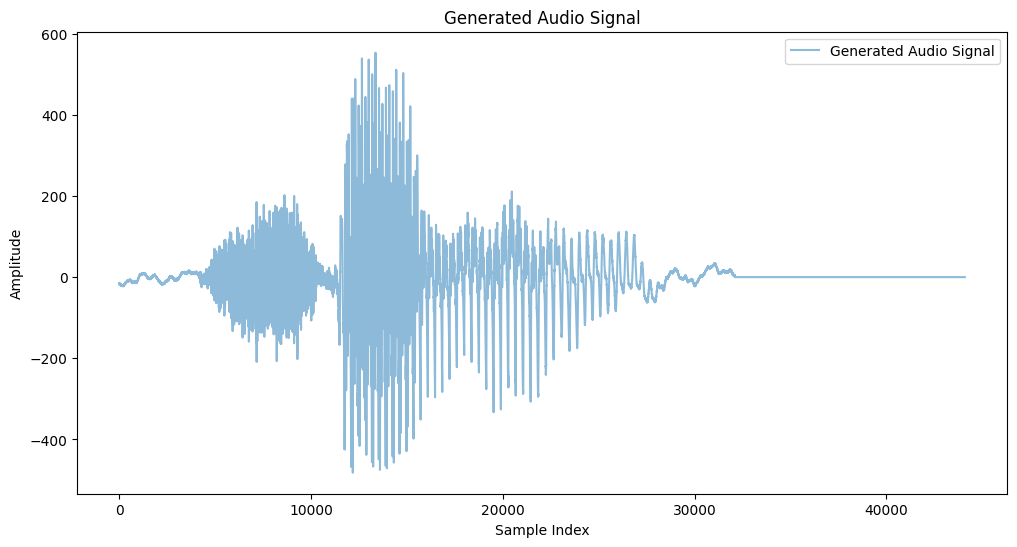

In [9]:
# plot the signal 
for batch in dataloader:
    # Plot the generated audio signal
    plt.figure(figsize=(12, 6))
    print(batch[0])
    plt.plot(batch[0], label='Generated Audio Signal', alpha=0.5)
    plt.title('Generated Audio Signal')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()
    break

## Setup the hyper-parameters

In [10]:
# Hyperparameters
input_dim = 1  # Input dimension for the RNN
hidden_dim = 128  # Hidden dimension for the RNN
output_dim = signal_length  # Output dimension (length of the signal)
z_dim = 10  # Dimension of the noise vector
batch_size = 16 # Batch size
num_epochs = 100  # Number of training epochs
learning_rate = 0.00002  # Learning rate

## Initialize the GANs

In [11]:
# Set up the GAN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize models
generator = Generator(z_dim, hidden_dim, output_dim=signal_length)
discriminator = Discriminator(signal_length, hidden_dim)

In [12]:
generator

Generator(
  (rnn): RNN(10, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=44100, bias=True)
)

In [13]:
discriminator

Discriminator(
  (rnn): RNN(44100, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

## Define the loss function and optimizers

In [14]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.SGD(generator.parameters(), lr=learning_rate, momentum=0.015)
d_optimizer = torch.optim.SGD(discriminator.parameters(), lr=learning_rate, momentum=0.015)
g_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(g_optimizer, T_0=10, T_mult=1, eta_min=0.00001, last_epoch=-1)
d_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(d_optimizer, T_0=10, T_mult=1, eta_min=0.00001, last_epoch=-1)
num_epochs = 10

## Training the GAN

In [ ]:
# Training loop
for epoch in range(num_epochs):
    for batch in dataloader: # batch is (batch_size, time_steps, features)
        # Generate fake signal
        noise = torch.randn(batch.size(0), 1, z_dim)  # Shape: (batch_size, seq_length, z_dim)
        generated_signal = generator(noise)
        # reshape for descriminator to accept Shape: (batch_size, seq_length, z_dim)
        generated_signal = torch.reshape(generated_signal, (batch.size(0), 1, signal_length))
        # Create labels
        real_labels = torch.ones(batch.size(0), 1)
        fake_labels = torch.zeros(batch.size(0), 1)

        # Train the discriminator
        discriminator.zero_grad()
        t = torch.reshape(batch, (batch.size(0), -1, signal_length))
        real_output = discriminator(t)  # Use the real audio batch
        real_loss = criterion(real_output, real_labels)
        fake_output = discriminator(generated_signal.detach())  # Use the generated signal
        fake_loss = criterion(fake_output, fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        d_optimizer.step()
        d_scheduler.step()

        # Train the generator
        generator.zero_grad()
        fake_output = discriminator(generated_signal.detach())  # Use the generated signal
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        g_optimizer.step()
        g_scheduler.step()

    #if epoch % 100 == 0:
        print(f'Epoch: {epoch}, Generator Loss: {g_loss.item()}, Discriminator Loss: {d_loss.item()}')

Epoch: 0, Generator Loss: 0.7867531180381775, Discriminator Loss: 1.344451665878296
Epoch: 0, Generator Loss: 0.7862800359725952, Discriminator Loss: 1.3531641960144043
Epoch: 0, Generator Loss: 0.7863107919692993, Discriminator Loss: 1.3521194458007812
Epoch: 0, Generator Loss: 0.7860647439956665, Discriminator Loss: 1.347222089767456
Epoch: 0, Generator Loss: 0.786018967628479, Discriminator Loss: 1.35262930393219
Epoch: 0, Generator Loss: 0.7859729528427124, Discriminator Loss: 1.3484249114990234
Epoch: 0, Generator Loss: 0.7868332862854004, Discriminator Loss: 1.3518056869506836
Epoch: 0, Generator Loss: 0.7857328653335571, Discriminator Loss: 1.3437716960906982
Epoch: 0, Generator Loss: 0.7859467267990112, Discriminator Loss: 1.3551459312438965
Epoch: 0, Generator Loss: 0.7861385345458984, Discriminator Loss: 1.3431615829467773
Epoch: 0, Generator Loss: 0.7865753769874573, Discriminator Loss: 1.3479597568511963
Epoch: 0, Generator Loss: 0.7850871682167053, Discriminator Loss: 1.35

## Generate new signals after training

In [ ]:
# Set the generator to evaluation mode
generator.eval()
# Generate and visualize a sample output
with torch.no_grad():
    noise = torch.randn(1, 1, z_dim)  # Shape: (batch_size, seq_length, z_dim)
    generated_audio = generator(noise).detach().numpy().flatten()
print(generated_audio.shape)
# Plot the generated audio signal
plt.figure(figsize=(12, 6))
plt.plot(generated_audio, label='Generated Audio Signal', alpha=0.5)
plt.title('Generated Audio Signal')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
# saving the output
np.save('generated/generated.npy', generated_audio)
from scipy.io.wavfile import write

# Assuming the array values are in the range of int16 for WAV format
# Scale the array if necessary
generated_audio = np.int16(generated_audio / np.max(np.abs(generated_audio)) * 32767)

# Save the array as a WAV file
write('generated/generated.wav', sample_rate, generated_audio) 